# Initial setup

In [1]:
%load_ext autoreload
%autoreload 2

import sys

if "../src" not in sys.path:
    sys.path.append("../src")

In [141]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

from auto_bpsm.petromod_project import PetroModProject
from auto_bpsm.petromod_models import OneDimensionalModel
from auto_bpsm.opensim_utils.present_day_results import get_layer_data, get_layers_indecies, get_layer_data_table

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

# Loading the project

In [124]:
project_folder = Path("../data/1d_model")
lithology_priors_filename = Path("../data/input_data/lithology_priors.csv")
calibration_filenames = {
    "Porosity (effective)": Path("../data/input_data/calibration_porosity.csv"),
    "Temperature": Path("../data/input_data/calibration_temperature.csv"),
    "Pore Pressure": Path("../data/input_data/calibration_pressure.csv"),
}
model_name = "ST168"

# Load project and model
project = PetroModProject(project_folder,petromod_folder_index=0)
lithology = project.load_lithology()
model : OneDimensionalModel = project.load_model(model_name)

# Load lithology priors
lithology_priors_table = pd.read_csv(lithology_priors_filename)

# Load calibration tables
calibration_tables = {prop: pd.read_csv(filename) for prop, filename in calibration_filenames.items()}

# Heat prior
heat_prior_mu = 47
heat_prior_sigma = 3

# Prepare variables
lithology_uncertain_properties = ["Athy's Factor k (depth)", "Anisotropy Factor Permeability", "Scaling Factor", "Specific Surface Area", "Initial Porosity"]
lithology_uncertain_properties_mu = [prop+"_mu" for prop in lithology_uncertain_properties]
lithology_uncertain_properties_sigma = [prop+"_sigma" for prop in lithology_uncertain_properties]
lithology_names = lithology_priors_table['lithology'].values

# Creating the priors

In [130]:
# Update lithology
for lithology_index, lithology_name in enumerate(lithology_names):

    # Get the random variable parameters
    sigmas = lithology_priors_table[lithology_uncertain_properties_sigma].iloc[lithology_index,:].values
    mus = lithology_priors_table[lithology_uncertain_properties_mu].iloc[lithology_index,:].values

    # Sample from normals
    property_values = np.random.normal(mus, sigmas)

    # Update the lithology
    property_dict = {prop:val for prop,val in zip(lithology_uncertain_properties, property_values)}
    lithology.update_lithology_parameter(lithology_name, property_dict)

project.save_lithology()

# Update heatflow
heat_value = np.random.normal(heat_prior_mu, heat_prior_sigma)
model.heat_flow.table['Value'] = heat_value
model.heat_flow.save()

# Run the model

In [131]:
# Run the model
log = project.run_model("ST168")

# Get the results
layer_names = ["Depth", "Porosity (effective)", "Temperature", "Pore Pressure"]
results_table = get_layer_data_table(project, model_name, layer_names)

# Plot results

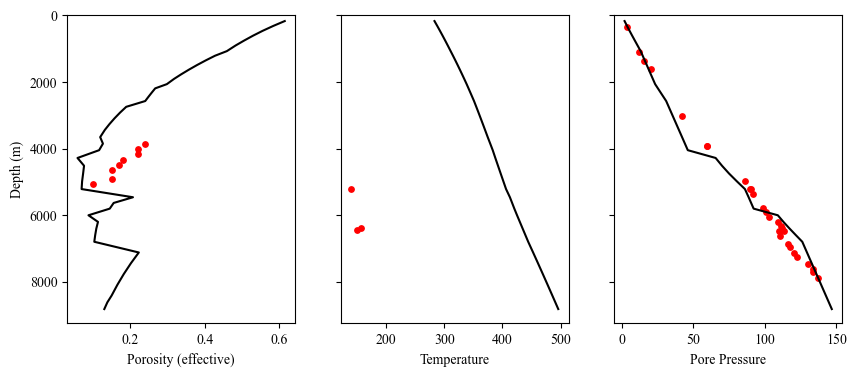

In [133]:
y = results_table["Depth"].values
fig, axs = plt.subplots(1,3, figsize=(10,4))

for i, layer_name in enumerate(layer_names[1:]):
    x = results_table[layer_name].values
    calibration_data = calibration_tables[layer_name]
    ax = axs[i]
    ax.plot(x, y, color='k')
    ax.set_ylim([0, None])
    ax.invert_yaxis()
    ax.set_xlabel(layer_name)
    if i==0:
        ax.set_ylabel("Depth (m)")
    else:
        ax.set_yticklabels([])

    y_calibration = calibration_data.iloc[:,0].values
    x_calibration = calibration_data.iloc[:,1].values
    ax.scatter(x_calibration, y_calibration, color='r', s=15)

# Calculate errors

In [145]:
y = results_table["Depth"].values

mean_square_errors = []
r_squareds = []
for i, layer_name in enumerate(layer_names[1:]):
    x = results_table[layer_name].values
    y_calibration = calibration_data.iloc[:,0].values
    x_calibration = calibration_data.iloc[:,1].values

    x_interp = np.interp(y_calibration, y,x)

    mse = mean_squared_error(x_calibration, x_interp)
    mean_square_errors.append(mse)
    r2 = r2_score(x_calibration, x_interp)
    r2 = np.max([0, r2])
    r_squareds.append(r2)

[0.0, 0.0, 0.9678288880061137]